In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
IMGSZ = 256
B_SIZE = 32
CHANNEL_SIZE = 3
EPOCHS = 50

In [3]:
datasets = tf.keras.preprocessing.image_dataset_from_directory(
    "PEPPER DATASETS",
    image_size=(IMGSZ,IMGSZ),
    shuffle=True,
    batch_size=B_SIZE
)

Found 2475 files belonging to 2 classes.


In [4]:
CLASS_NAMES = datasets.class_names
CLASS_NAMES

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

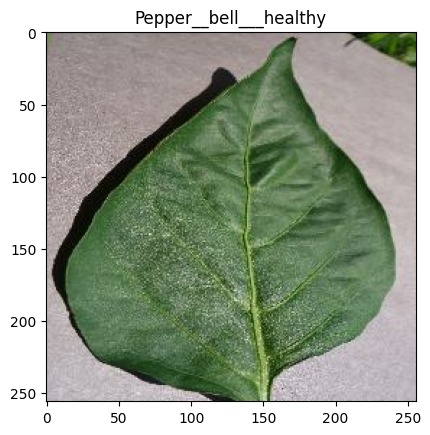

In [5]:
for image_batch, label_batch in datasets.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[label_batch[0]])

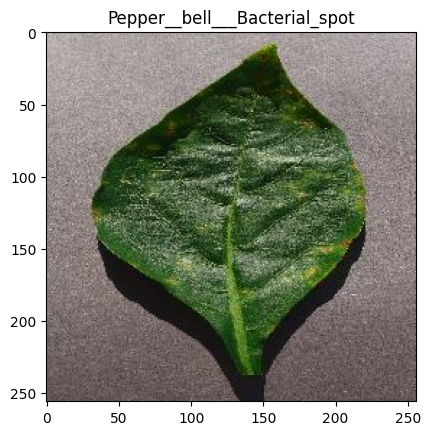

In [11]:
for image_batch, label_batch in datasets.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[label_batch[0]])

In [12]:
def get_train_test_eval_dataset(datasets, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    assert (train_size + test_size + val_size) == 1
    
    ds_size = len(datasets)
    
    if shuffle:
        datasets = datasets.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_size * ds_size)
    val_size = int(val_size * ds_size)
    
    train_dataset = datasets.take(train_size)    
    val_dataset = datasets.skip(train_size).take(val_size)
    test_dataset = datasets.skip(train_size).skip(val_size)
    
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = get_train_test_eval_dataset(datasets)

print("LENGTH OF TRAIN DATASET : ",len(train_dataset))
print("LENGTH OF TEST DATASET : ",len(test_dataset))
print("LENGTH OF EVAL DATASET : ",len(val_dataset))

LENGTH OF TRAIN DATASET :  62
LENGTH OF TEST DATASET :  9
LENGTH OF EVAL DATASET :  7


In [13]:
train_dataset = train_dataset.cache().shuffle(1000)
test_dataset = test_dataset.cache().shuffle(1000)
val_dataset = val_dataset.cache().shuffle(1000)

In [14]:
resize_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMGSZ,IMGSZ),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255),
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

pepper_model = tf.keras.Sequential([
    resize_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape = (B_SIZE,IMGSZ,IMGSZ,CHANNEL_SIZE)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2,activation="softmax")

])

pepper_model.build(input_shape=(B_SIZE,IMGSZ,IMGSZ,CHANNEL_SIZE))
pepper_model.summary()

pepper_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [15]:
history_rec = pepper_model.fit(
    train_dataset,
    epochs=50,
    batch_size=B_SIZE,
    verbose=1,
    validation_data=val_dataset
)

Epoch 1/50
62/62 [==============================] - 98s 1s/step - loss: 0.5731 - accuracy: 0.7132 - val_loss: 0.5839 - val_accuracy: 0.7679
Epoch 2/50
62/62 [==============================] - 104s 2s/step - loss: 0.1670 - accuracy: 0.9389 - val_loss: 0.1701 - val_accuracy: 0.9330
Epoch 3/50
62/62 [==============================] - 99s 2s/step - loss: 0.1072 - accuracy: 0.9587 - val_loss: 0.0334 - val_accuracy: 0.9911
Epoch 4/50
62/62 [==============================] - 94s 2s/step - loss: 0.0829 - accuracy: 0.9776 - val_loss: 0.0797 - val_accuracy: 0.9598
Epoch 5/50
62/62 [==============================] - 91s 1s/step - loss: 0.0618 - accuracy: 0.9842 - val_loss: 0.2897 - val_accuracy: 0.8438
Epoch 6/50
62/62 [==============================] - 95s 2s/step - loss: 0.0699 - accuracy: 0.9776 - val_loss: 0.0947 - val_accuracy: 0.9554
Epoch 7/50
62/62 [==============================] - 89s 1s/step - loss: 0.0285 - accuracy: 0.9903 - val_loss: 0.0140 - val_accuracy: 0.9955
Epoch 8/50
62/62 [=

In [16]:
accuracy_pm = history_rec.history['accuracy']
loss_pm = history_rec.history['loss']
val_accuracy_pm = history_rec.history['val_accuracy']
val_loss_pm = history_rec.history['val_loss']

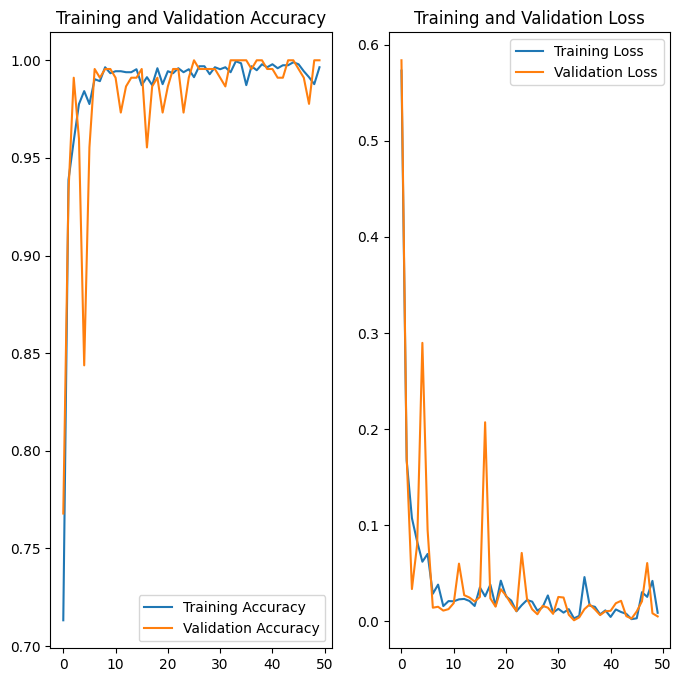

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), accuracy_pm, label='Training Accuracy')
plt.plot(range(50), val_accuracy_pm, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss_pm, label='Training Loss')
plt.plot(range(50), val_loss_pm, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
pepper_model.evaluate(test_dataset)

9/9 [==============================] - 3s 274ms/step - loss: 0.6032 - accuracy: 0.9931


[0.6032370924949646, 0.9930555820465088]

1/1 [==============================] - 0s 31ms/step


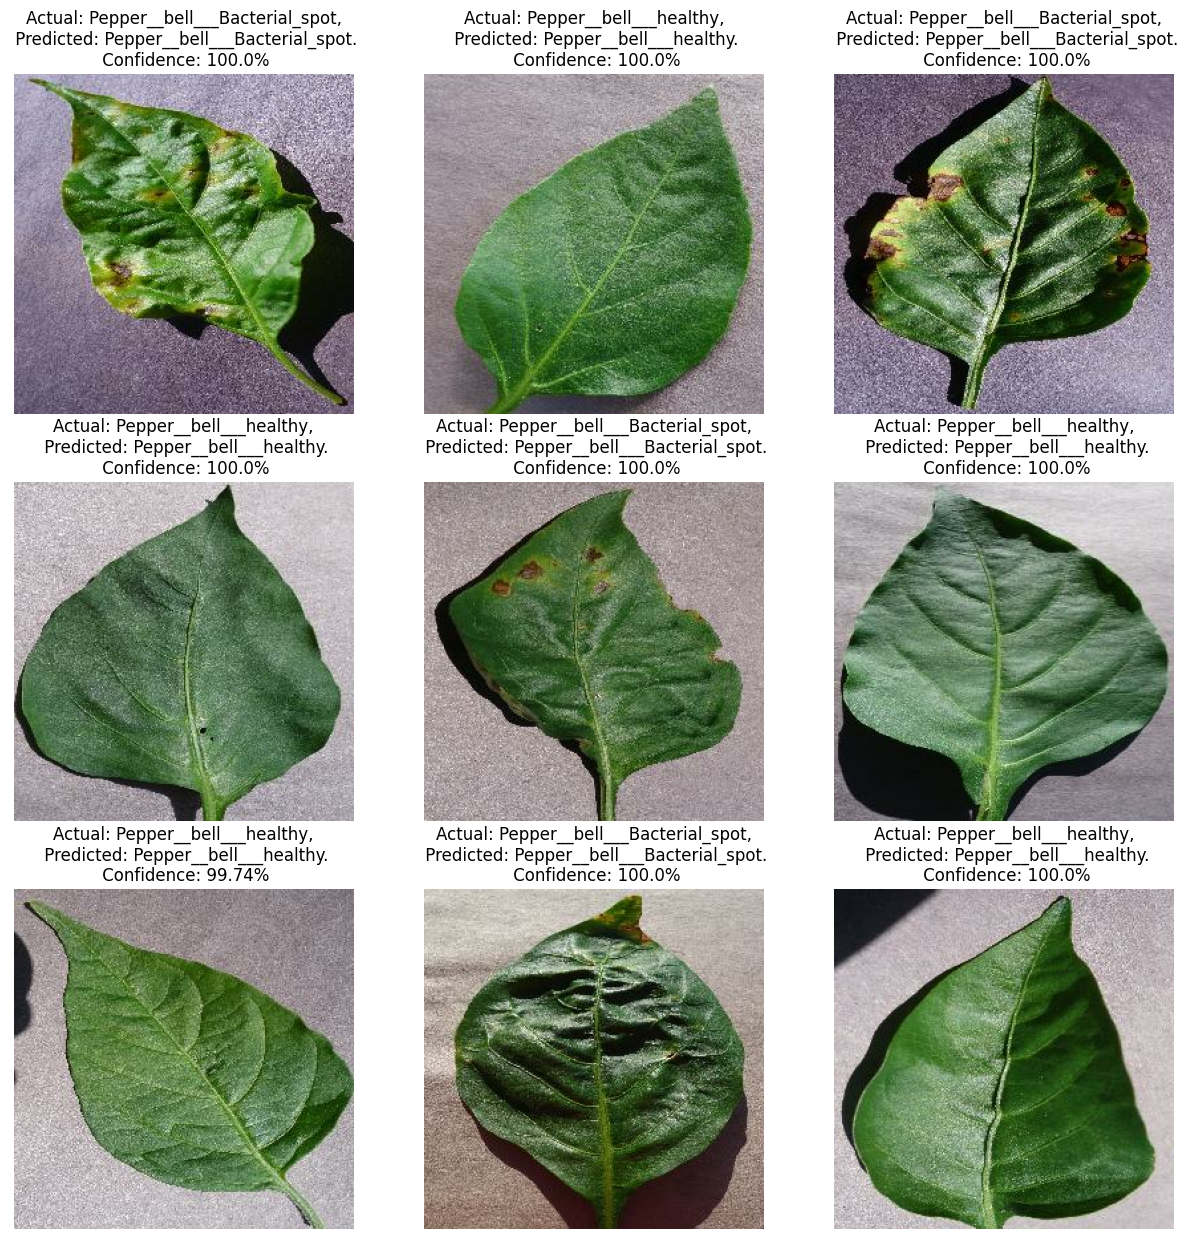

In [18]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        IMG = images[i].numpy()
        plt.imshow(IMG.astype("uint8"))

        img_array = tf.expand_dims(IMG, 0)

        predictions = pepper_model.predict(img_array)

        predicted_class = CLASS_NAMES[np.argmax(predictions[0])]
        confidence = round(100 * (np.max(predictions[0])), 2)
        actual_class = CLASS_NAMES[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [20]:
model_version = 2
pepper_model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/2\assets


INFO:tensorflow:Assets written to: ./models/2\assets
